In [68]:
import pandas as pd

In [2]:
# instead of importing all the bigrams, it might be simplest just to only generate the econ bigrams
articles = pd.read_csv('../process_articles/processed_articles.csv')
print(len(articles))
# drop the ones that don't have text
articles = articles.dropna(subset=['text'])
print(len(articles))

In [185]:
from operator import itemgetter
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
nltk.download('punkt')


def get_term_ngrams(text, n, term):
    n_grams = ngrams(word_tokenize(text), n)
    return [ ''.join(grams) for grams in n_grams if term in grams]


def ngram_term_counts(ngram):
    # create word count dictionary
    word_count = {}

    for word in ngram:
        if word in word_count.keys():
            cur_val = word_count[word]
            cur_val += 1
            word_count[word] = cur_val
        else:
            word_count[word] = 1

    # sort the dictionary
    word_count = {k: v for k, v in sorted(word_count.items(), key=lambda item: item[1], reverse=True)}

    return word_count


def get_top_n_ngrams(df:pd.DataFrame, term:str, top_k:int, ngram:int, stopwords=None) -> list:
    """Returns unique list of the combined k most-occuring ngrams for each quarter
    
    Creates a list of ngrams containing the term for each article, counts occurance of each, 
    and then creates a combined total for all ngrams in the quarter. Finds k most common ngrams
    in each quarter, and then combines the unique ngrams into one list.

    Args:
        df (pd.DataFrame):
            Dataframe of the articles
        term (str):
            Chinese word (doesn't handle phrases) to find the context of. 
        top_k (int):
            Number of ngrams per quarter you want to include. For example, top_k = 1
            only combines the single most frequent ngrams from each quarter. top_k = 2
            combines the two most frequent ngrams from each quarter. 
        ngram (int):
            Length in words of ngrams to be calculated.
        stopwords (list(str)):
            ngrams to exclude, like "经济和" (which is already exluded by default)
        
    Returns:
        List of the unqiue words that occured at least once in the top k ngrams for one of 
        the quarters. 

    Examples:
        ```
        # returns list of bigrams that were the most frequent in at least one quarter
        get_top_n_ngrams(articles, "经济", 1, 2)

        # returns list of trigrams that were in the top 2 for at least one quarter
        get_top_n_ngrams(articles, "经济", 2, 3)
        ```
    """
    # generate and store the ngrams for each article that contain the term
    df[term+'_bigram'] = df['cleaned_text_wspaces'].map(lambda x: get_term_ngrams(x, ngram, term))
    # print(df[term+'_bigram'].head(10))
    # print()

    # calculate and store ngram count dictionary for each article
    df[term+'_bigram_count'] = df[term+'_bigram'].map(lambda x: ngram_term_counts(x))
    # print(df[term+'_bigram_count'].head(10))

    # create an empty dictionary to store the term-counts for each quarter
    quarters = list(df['year_quarter'].unique())
    quarters.sort()

    quarter_ngrams = {}
    for quarter in quarters:
        quarter_ngrams[quarter] = {}
    # print(quarter_ngrams)

    # calculate the complete list of ngrams and their counts for each quarter
    for index, row in articles.iterrows():
        year_quarter = row['year_quarter']

        quarter_ngrams[year_quarter] = {i: row[term+'_bigram_count'].get(i, 0) + quarter_ngrams[year_quarter].get(i, 0) 
            for i in set(row[term+'_bigram_count']).union(quarter_ngrams[year_quarter])}
    print(quarter_ngrams)

    # drop unwanted ngrams
    # declare a list that will store [quarter, key_to_drop] pairs
    to_drop = []
    for quarter in quarter_ngrams:
        # drop any user-defined stopwords - basic ngrams that shouldn't be included
        if stopwords:
            for stopword in stopwords:
                if stopword in quarter_ngrams[quarter].keys():
                    quarter_ngrams[quarter].pop(stopword)
        # drop things that start or end in 对， 在， 像，和， 与，同，了，以，而，为
        auto_drops = ['对', '在', '像','和','与','同','了','以','而','为','的','比','是']
        for key in quarter_ngrams[quarter].keys():
            if (key[0] in auto_drops or key[-1] in auto_drops) and (len(key) <= len(term) + 2*(ngram-2) + 1):
                to_drop.append([quarter, key])

    for quarter, key_to_drop in to_drop:
        quarter_ngrams[quarter].pop(key_to_drop)
    
    print(f"Dropped keys: {set([key for quarter, key in to_drop])}")

    # get the top n most common terms for each quarter
    top_n_pairs = {}
    for quarter in quarter_ngrams:
        top_n_pairs[quarter] = dict(sorted(quarter_ngrams[quarter].items(), key=itemgetter(1), reverse=True)[:top_k])    
    print(f"Top n most common terms: {top_n_pairs}")

    # extract the list of the most common terms for all quarters
    terms = []
    for quarter in top_n_pairs:
        for term in top_n_pairs[quarter]:
            terms.append(term)
    terms = list(set(terms))

    return terms

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/calebharding/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
get_top_n_ngrams()

In [166]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from ipynb.fs.full.frequency_analysis import quarter_count

path = '/Users/calebharding/Documents/BYU/2023-2024/China_Project/qiushi_venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/NotoSansSC-Regular.ttf'
font = font_manager.FontProperties(fname=path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = font.get_name()

def graph_top_n_ngrams(terms, title, y_lim=None, articles_df=None):
    if len(terms) > 5:
        fig, axs = plt.subplots(len(terms), sharex=True, sharey=True, figsize=(6, 10))

        clrs = sns.color_palette(n_colors=len(terms))

        for index, term in enumerate(terms):
            term_quarter_count = quarter_count(articles, term)
            xvals = list(term_quarter_count.keys())[:-1]
            yvals = list(term_quarter_count.values())[:-1]

            axs[index].plot(xvals, yvals, c=clrs[index])
            axs[index].legend([term])
            axs[index].set(xlabel='Quarter')
            axs[index].grid()
            axs[index].label_outer()
            axs[index].tick_params(axis='x', rotation=50)

            if y_lim:
                axs[index].set_ylim(y_lim)

        fig.suptitle(title)
        fig.supylabel("Instance Count")
        fig.tight_layout()
    else:
        fig, ax = plt.subplots()

        for term in terms:
            try:
                term_quarter_count = quarter_count(articles_df, term)
                xvals = list(term_quarter_count.keys())[:-1]
                yvals = list(term_quarter_count.values())[:-1]

                ax.plot(xvals, yvals, label=term)
            except:
                raise Exception("Error counting term in articles. Verify articles_df was provided")
            
        ax.set_xlabel("Quarter")
        ax.set_ylabel("Instance Counts")
        if y_lim:
            ax.set_ylim(y_lim)
        ax.set_title(title)
        ax.legend(prop=font)
        ax.tick_params(axis='x', rotation=50)
        ax.grid()

    # plt.savefig(f"../visuals/{save_string}frequency.png", bbox_inches='tight')
    plt.show()


In [167]:
terms = get_top_n_ngrams(articles, "经济", 1, 2)

{'2019 Q1': {'经济仍然': 1, '经济接近': 1, '经济立法': 1, '社会经济': 1, '应对经济': 1, '日本经济': 3, '多种经济': 1, '是经济': 9, '经济合作': 6, '经济走势': 1, '经济毫不动摇': 1, '北京经济': 1, '经济扩张': 1, '经济联动': 1, '经济活动': 5, '经济内生': 1, '经济政策': 5, '辉煌成就经济': 1, '对经济': 8, '促进经济': 8, '作为经济': 2, '在经济': 9, '区域经济': 3, '做好经济': 2, '意识形态经济': 3, '充分运用经济': 1, '经济积极参与': 1, '制定经济': 1, '南非经济': 1, '管理经济': 1, '调节经济': 1, '经济类': 1, '意味着经济': 1, '把经济': 3, '经济长期': 4, '经济决定论': 1, '无人经济': 1, '经济改革': 1, '全球经济': 12, '转变经济': 2, '局面经济': 1, '优化经济': 1, '各种经济': 1, '近年来经济': 1, '初见成效经济': 1, '万经济': 1, '经济深层次': 1, '必然结果经济': 1, '中央经济': 12, '推动经济': 18, '融入经济': 1, '经济发展前景': 1, '东盟国家经济': 1, '进行经济': 1, '经济结构': 10, '归咎于经济': 1, '经济持续': 8, '经济积极': 1, '俄经济': 2, '经济开放': 1, '向经济': 1, '经济实力': 1, '一切经济': 1, '经济发展壮大': 1, '经济高质量': 14, '货币贬值经济': 2, '经济从': 4, '经济这个': 1, '经济增长': 53, '经济大幅': 1, '经济双重': 1, '有关经济': 2, '年经济': 5, '刺激经济': 1, '经济制度': 14, '经济改善': 2, '公有制经济': 1, '经济复苏': 9, '经济一度': 1, '做大经济': 1, '经济篇': 1, '经济财富': 2, '各国经济': 2, '活经济': 1, '经济将': 1, '经济继续': 1, '数字经济': 5, '经济规模':

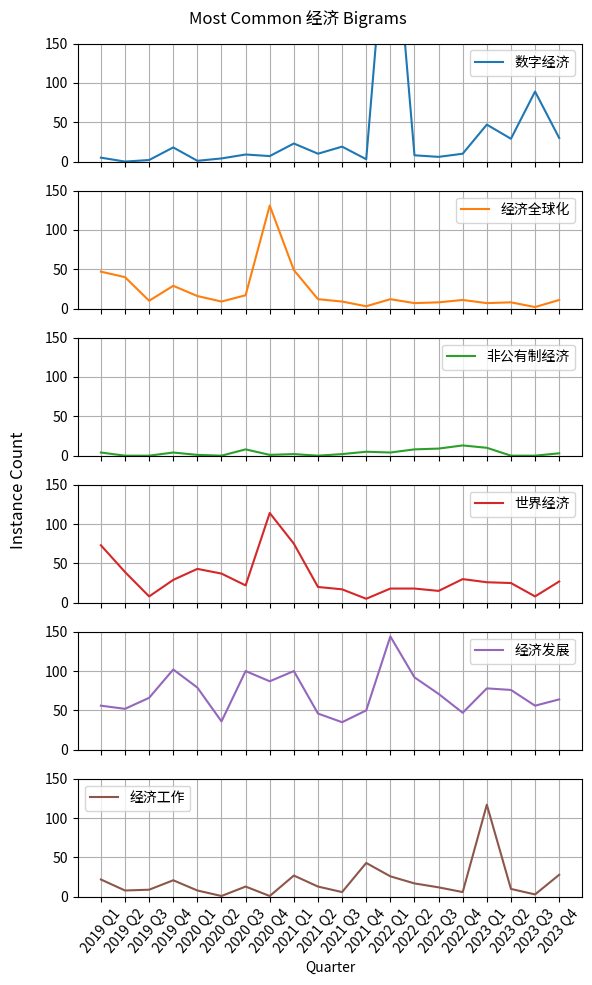

In [144]:
graph_top_n_ngrams(terms, "Most Common 经济 Bigrams", y_lim=[0, 150])

In [145]:
terms = get_top_n_ngrams(articles, "经济", 2, 2)

{'2019 Q1': {'经济仍然': 1, '经济接近': 1, '经济立法': 1, '社会经济': 1, '应对经济': 1, '日本经济': 3, '多种经济': 1, '是经济': 9, '经济合作': 6, '经济走势': 1, '经济毫不动摇': 1, '北京经济': 1, '经济扩张': 1, '经济联动': 1, '经济活动': 5, '经济内生': 1, '经济政策': 5, '辉煌成就经济': 1, '对经济': 8, '促进经济': 8, '作为经济': 2, '在经济': 9, '区域经济': 3, '做好经济': 2, '意识形态经济': 3, '充分运用经济': 1, '经济积极参与': 1, '制定经济': 1, '南非经济': 1, '管理经济': 1, '调节经济': 1, '经济类': 1, '意味着经济': 1, '把经济': 3, '经济长期': 4, '经济决定论': 1, '无人经济': 1, '经济改革': 1, '全球经济': 12, '转变经济': 2, '局面经济': 1, '优化经济': 1, '各种经济': 1, '近年来经济': 1, '初见成效经济': 1, '万经济': 1, '经济深层次': 1, '必然结果经济': 1, '中央经济': 12, '推动经济': 18, '融入经济': 1, '经济发展前景': 1, '东盟国家经济': 1, '进行经济': 1, '经济结构': 10, '归咎于经济': 1, '经济持续': 8, '经济积极': 1, '俄经济': 2, '经济开放': 1, '向经济': 1, '经济实力': 1, '一切经济': 1, '经济发展壮大': 1, '经济高质量': 14, '货币贬值经济': 2, '经济从': 4, '经济这个': 1, '经济增长': 53, '经济大幅': 1, '经济双重': 1, '有关经济': 2, '年经济': 5, '刺激经济': 1, '经济制度': 14, '经济改善': 2, '公有制经济': 1, '经济复苏': 9, '经济一度': 1, '做大经济': 1, '经济篇': 1, '经济财富': 2, '各国经济': 2, '活经济': 1, '经济将': 1, '经济继续': 1, '数字经济': 5, '经济规模':

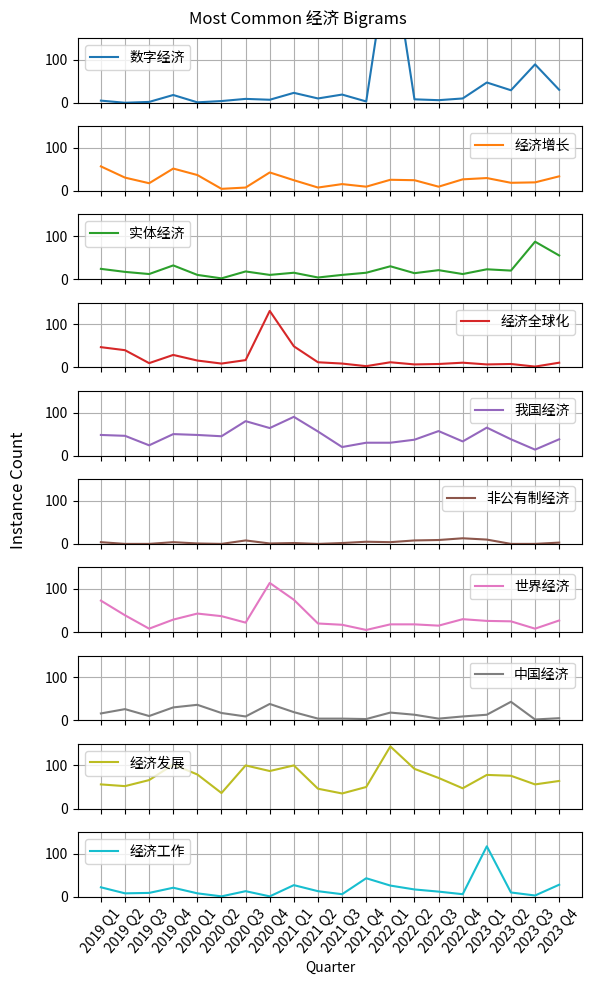

In [146]:
graph_top_n_ngrams(terms, "Most Common 经济 Bigrams", y_lim=[0, 150])

In [168]:
terms = get_top_n_ngrams(articles, "经济", 1, 3)
terms

{'2019 Q1': {'环境经济政策': 1, '单一的经济': 2, '阐述了经济': 1, '经济发展部长': 1, '经济增长带来': 1, '为经济制度': 1, '货币贬值经济减速': 1, '对新形势下经济': 1, '经济得到可喜': 1, '经济仍然是': 1, '经济发展落后': 1, '年均经济增长率': 1, '各项单行经济': 1, '降低实体经济': 1, '国内经济出现': 1, '经济下行压力': 5, '经济总体延续': 1, '简单归咎于经济': 1, '经济政策和': 1, '一个大国经济': 1, '中发展经济': 1, '国家经济建设': 1, '了在经济': 1, '经济形势严峻货币贬值': 1, '历史唯物主义关于经济': 2, '民主化等经济': 1, '实体经济深度': 3, '经济工作最': 1, '区间经济结构': 1, '归咎于经济全球化': 1, '经济增速趋于': 1, '迹象发达国家经济': 1, '发达国家经济增速': 1, '国际经济合作': 1, '中国经济要': 1, '看经济全球化': 2, '风险保持经济': 1, '衰退但经济': 1, '经济活动客体': 1, '美国经济增速': 1, '问题在经济': 1, '占世界经济': 1, '经济在世界': 1, '在促进经济': 1, '转化为经济': 1, '世界经济积极参与': 1, '经济改善贫困': 1, '日本经济增长': 3, '实体经济一定': 1, '当前世界经济': 1, '做大经济规模': 1, '世界经济复苏': 5, '经济政治上': 1, '通过经济类': 1, '能力经济长期': 1, '根据地政权建设经济': 1, '区域经济合作': 1, '经济板块经贸': 1, '涉及经济建设': 1, '现代化经济体系': 9, '生产方式经济形态': 1, '实体经济上': 1, '发展经济是': 2, '经济一定要': 1, '参与全球经济': 1, '经济迎难而上坚定不移': 1, '经济稳中有变': 1, '经济增长贡献率': 4, '经济要发展': 1, '发展转变经济': 1, '发展保持经济': 1, '顺应经济全球化': 1, '人工智能新增经济': 1, '我们关于经济': 1, '经济发展的': 9, 

['数字经济发展',
 '世界经济增长',
 '现代化经济体系',
 '中央经济工作',
 '中国经济发展',
 '社会主义基本经济',
 '我国经济发展',
 '经济全球化的',
 '经济和实体',
 '经济工作会议',
 '经济高质量发展',
 '经济下行压力']

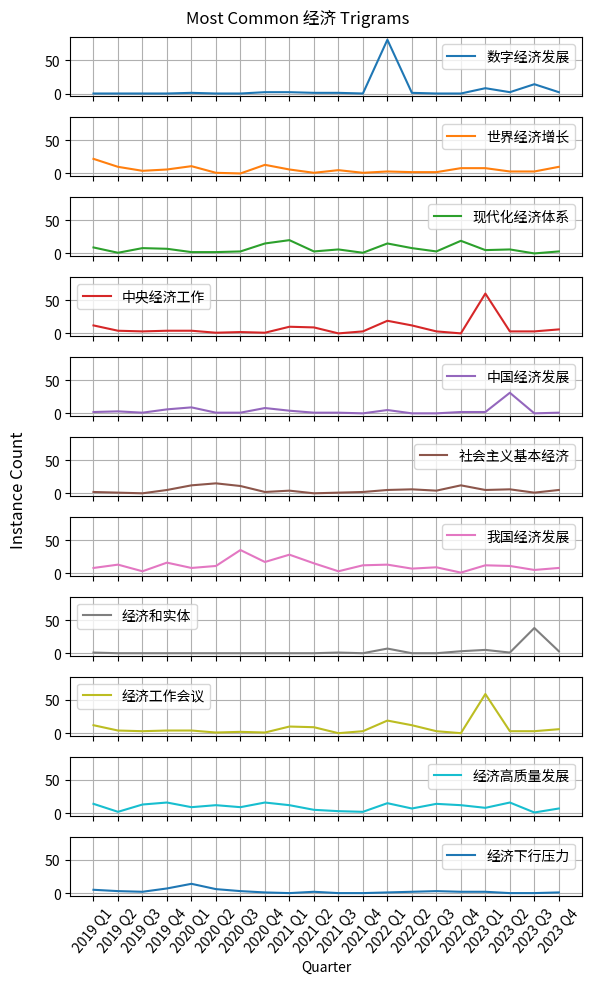

In [169]:
terms.remove('经济全球化的')
graph_top_n_ngrams(terms, "Most Common 经济 Trigrams")

In [158]:
terms = get_top_n_ngrams(articles, "国际", 1, 3)
terms

{'2019 Q1': {'继续引发国际': 1, '程度企业国际': 1, '引导国际秩序': 1, '环境署等国际': 1, '在国际国内形势': 1, '和国际比武': 1, '一道打造国际': 1, '国际分工协作是': 1, '国际国内形势完成': 1, '国际社会对': 1, '风险不让国际': 1, '平衡国际油价': 1, '四国际收支平衡': 1, '国际金融危机发生': 1, '国际先进水平': 1, '的国际影响力': 1, '国际机构一道': 1, '建设国际一流': 3, '企业提升国际': 1, '国际国内风险': 1, '领域的国际': 1, '国际机场视觉': 1, '要积极参与国际': 1, '形成国际合作': 1, '最低水平四国际': 1, '基本平衡国际': 1, '国际社会普遍': 1, '全球化充分利用国际': 1, '能力不足国际': 1, '陆家嘴国际金融中心': 1, '国际商事争端': 1, '照搬国际金融危机': 1, '仍处于国际': 1, '是根据国际': 1, '地区和国际': 1, '国际金融危机后': 1, '难以重现国际': 1, '发展到国际': 1, '日本海国际空域': 1, '等国际机构': 1, '国际国内形势的': 2, '国际经济合作': 1, '国际进口博览会': 7, '第二届中国国际': 1, '领域国际合作': 1, '国际金融危机以来': 1, '在国际著名': 1, '巩固国际社会': 1, '市场国际融资': 1, '基础的国际': 1, '弊端积重难返国际': 1, '国内国际两个': 4, '国际论坛的': 1, '一种新型国际': 1, '国际油价持续': 1, '国际油价支撑': 1, '国际社会作出': 1, '小商品城国际': 1, '国际影响力的': 1, '形成具有国际': 1, '国际格局已': 1, '国际金融危机爆发': 6, '国际秩序观': 2, '中国国际进口': 7, '引领国际合作': 1, '社会进步国际': 1, '年国际油价': 2, '秩序和国际': 1, '同国际社会': 1, '的国际竞赛': 1, '气候变化国际合作': 1, '国际合作要': 1, '国际关系问题': 1, '首届中国国际': 4, '国际风险等': 1, '

['疫情防控国际',
 '国际进口博览会',
 '国际科技竞争',
 '国际传播能力',
 '一带一路国际',
 '站在国际',
 '国内国际双循环',
 '更具国际影响力',
 '数字经济国际',
 '新型国际关系',
 '履行国际义务',
 '大兴国际机场']

In [177]:
terms = get_top_n_ngrams(articles, "中国", 3, 2)
terms

{'2019 Q1': {'中国劳动生产率': 1, '中国之所以': 2, '紧迫性中国': 1, '中国大踏步': 2, '中国天眼': 7, '延伸中国': 1, '中国生态': 1, '中国必将': 4, '中国为': 1, '明确指出中国': 2, '中国点赞': 1, '中国百姓': 1, '关系中国': 2, '获中国': 1, '万美元中国': 1, '中国数据': 1, '中国共同努力': 1, '中国纪检监察': 1, '中国习近平': 1, '富是中国': 1, '到中国': 4, '首届中国': 4, '时期中国': 2, '今天中国': 4, '那句中国': 1, '统筹中国': 1, '立场中国': 1, '包括中国': 1, '中国深刻': 1, '一股中国': 1, '中国走向': 1, '加深中国': 1, '中国推动': 3, '方方面面中国': 1, '之义中国': 1, '内政中国': 1, '因素中国': 1, '到底中国': 1, '中国要举': 1, '中国火药': 1, '中国奇迹': 3, '中国右图': 1, '中国不断扩大': 3, '中国不': 3, '中国助推': 2, '中国第一辆': 1, '庄严宣告中国': 2, '四是中国': 1, '中国国内': 2, '中国艰苦卓绝': 1, '提出中国': 1, '中国取得': 1, '息息相关中国': 1, '中国大约': 1, '中国具体': 4, '中国一代代': 1, '中国一切': 1, '自从中国': 1, '中国从': 2, '基因中国': 1, '带来中国': 1, '全中国': 1, '中国互联网络': 1, '几代中国': 3, '中国制造': 2, '中国丝绸': 3, '搭乘中国': 2, '中国这么': 1, '中国理念': 3, '中国传媒大学': 1, '加强中国': 2, '洞察中国': 1, '纳入中国': 1, '外交中国': 1, '中国伟大成就': 1, '二是中国': 1, '中国丝路': 1, '把握中国': 3, '统计数据中国': 1, '中国成立': 18, '综合国力中国': 1, '复旦大学中国': 2, '中国推到': 1, '中国半殖民地': 2, '教师爷中国': 1, '从中国': 5, '新篇章中国

['时代中国', '中国特色', '中国革命', '新中国', '中国人民', '中国人权', '美丽中国', '当代中国']

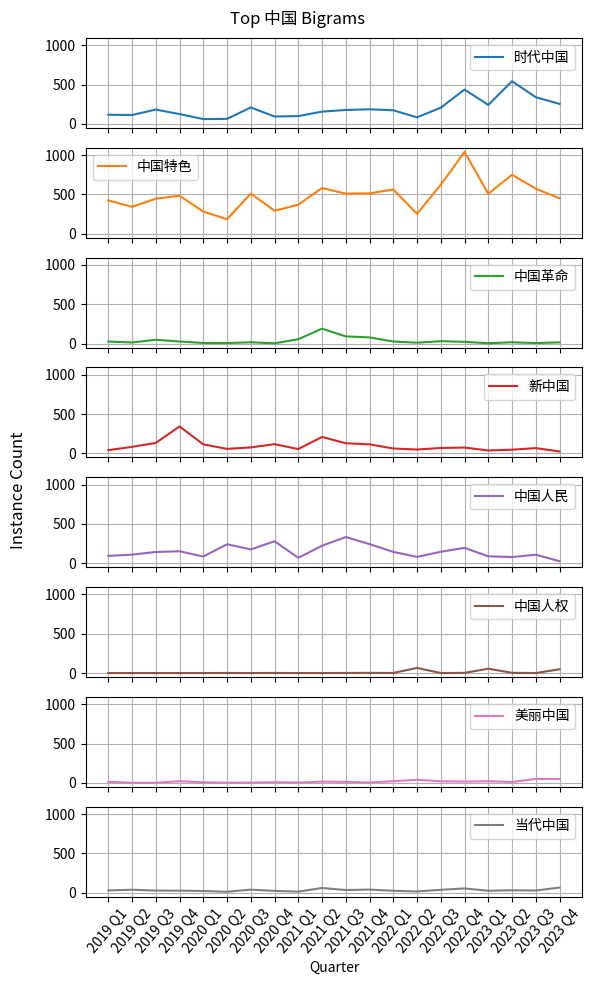

In [178]:
graph_top_n_ngrams(terms, "Top 中国 Bigrams", articles_df=articles)

In [186]:
terms = get_top_n_ngrams(articles, "疫情", 2, 2)
terms

{'2019 Q1': {}, '2019 Q2': {'疫情此伏': 1, '饥荒疫情': 1}, '2019 Q3': {'疫情2008': 1, '非典疫情': 2, '疫情给': 1}, '2019 Q4': {'防控疫情': 1, '饥荒疫情': 1, '猪瘟疫情': 1, '疫情防控': 1, '疫情此伏': 1, '疫情恢复': 1}, '2020 Q1': {'动植物疫情': 1, '高度重视疫情': 3, '三农疫情': 1, '安全疫情': 2, '克服疫情': 2, '疫情复炽': 1, '疫情解放军报': 1, '疫情而': 2, '重要疫情': 1, '疫情态势': 1, '因为疫情': 1, '支持疫情': 2, '疫情队伍': 1, '融入疫情': 1, '疫情风险': 2, '破坏疫情': 2, '疫情得到': 1, '研究成果疫情': 1, '财政疫情': 1, '不力疫情': 1, '于疫情': 1, '疫情病毒': 2, '疫情防治': 2, '要求疫情': 1, '一线疫情': 4, '隔离疫情': 1, '疫情科研人员': 1, '疫情严重': 8, '打赢疫情': 93, '武汉疫情': 4, '疫情防控': 894, '拓展疫情': 2, '来疫情': 1, '随着疫情': 2, '疫情可溯': 2, '疫情重点': 5, '疫情严峻': 3, '当疫情': 1, '提高疫情': 7, '疫情威胁': 3, '进行疫情': 3, '疫情结束': 1, '疫情牵动': 1, '心理健康疫情': 1, '疫情法治': 1, '深入疫情': 1, '疫情哄抬物价': 5, '根本保证疫情': 1, '疫情汹涌': 1, '疫情医疗': 4, '与疫情': 7, '疫情如何': 1, '疫情对': 20, '疫情每': 1, '疫情蔓延': 34, '疫情共产党员': 1, '首要任务疫情': 1, '疫情构筑': 2, '疫情元凶': 1, '疫情分区': 1, '疫情不仅': 1, '生产力疫情': 1, '强化疫情': 6, '保障疫情': 11, '流行疫情': 1, '当前疫情': 17, '配合疫情': 7, '疫情这么': 1, '主心骨疫情': 1, '承诺疫情': 1, '成为疫情': 3, '短板疫情': 1

['防控疫情', '肺炎疫情', '疫情此伏', '疫情2008', '饥荒疫情', '新冠疫情', '疫情防控', '非典疫情']

In [192]:
terms = get_top_n_ngrams(articles, "人权", 1, 3)
terms

{'2019 Q1': {'人权史上具有': 1, '人权理事会第': 1, '发展和人权': 1, '联合国人权理事会': 1, '的在人权': 1, '和世界人权': 1, '和人权进步': 1, '在人权领域': 1, '人权进步划时代': 1, '人权领域促进': 1, '举行联合国人权': 1, '世界人权史上': 1}, '2019 Q2': {'研究院人权研究': 1, '知识产权人权法治': 1, '和人权理事会': 1, '金融体系知识产权人权': 1, '联合国教科文组织和人权': 1, '人权理事会等': 1, '人权研究中心': 1, '人权法治和': 1, '治理研究院人权': 1}, '2019 Q3': {'人权免遭恐怖主义': 1, '基本人权免遭': 1, '司法制度完善人权': 1, '的基本人权': 1, '完善人权司法': 1, '人权司法保障制度': 1}, '2019 Q4': {'标榜民主自由人权': 1, '民主自由人权的': 1, '人权的帝国主义': 1}, '2020 Q1': {'基本人权不能': 1, '人权司法保障': 1, '强化人权司法': 1, '基本人权的': 1, '人权等问题': 1, '涉疆涉藏人权': 1, '涉藏人权等': 1, '保障基本人权': 2, '行为强化人权': 1, '人权的原则': 1, '人权不能突破': 1}, '2020 Q2': {'消极人权和': 1, '全人类基本人权': 1, '基本人权具有': 1, '发展促进人权': 1, '把人权考虑': 1, '抗疫中人权': 1, '中人权保障': 1, '坚持人权的': 1, '人权的载体': 1, '人权定位符合': 1, '其他一切人权': 1, '了普遍性人权': 1, '基本人权探索': 1, '促进人权保护': 1, '人权保护制度': 1, '推动我国人权': 3, '人权保护的': 2, '国际人权事业': 1, '我国人权事业': 4, '的人权状况': 1, '人权公约设定': 1, '人权理论在': 1, '人权随着福利': 1, '整个人权大厦': 1, '更没有人权': 1, '人权主要是因为': 1, '人权事业的': 1, '和保护人权': 1, '认为是人权': 1, '是人权保护':

['人权的最高',
 '人权史上具有',
 '涉疫人权等',
 '推进中国人权',
 '民主自由人权的',
 '联合国人权理事会',
 '时代中国人权',
 '保障基本人权',
 '西藏人权事业',
 '人权免遭恐怖主义',
 '推动我国人权',
 '人权事业发展',
 '治理推动人权',
 '我国人权事业',
 '不是所谓人权',
 '美国人权虚伪',
 '研究院人权研究',
 '全球人权治理',
 '标榜民主自由人权']

#### Ngl, this was... not has helpful/useful as I hoped. We need a way to dynamically parse which phrases are the most common, and it would be great if we could compare between them in a way that actually worked... like if we could do 数字经济 and 经济高质量发展